# 02: Feature Correlation & Selection for PCOS Prediction

**Goal:** Identify the clinical features most strongly associated with PCOS diagnosis.

**Research Question:** Which biomarkers indicate the strongest correlation with PCOS status?

**Methods:**
- Correlation analysis
- Statistical testing (t-tests)
- Feature importance via Random Forest

---

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [30]:
# Load data from GitHub
df = pd.read_csv("https://raw.githubusercontent.com/candpixie/pcos-informatics/main/data/PCOS_infertility.csv")
#Remove ID columns (they're not real features)
df = df.drop(['SI. No', 'Patient File No.'], axis=1, errors='ignore')
print(f"Cleaned dataset shape: {df.shape}")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Cleaned dataset shape: (541, 5)
Dataset shape: (541, 5)

Columns: ['Sl. No', 'PCOS (Y/N)', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)']


,Sl. No,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,0,1.99,1.99,2.07
1,2,0,60.80,1.99,1.53
2,3,1,494.08,494.08,6.63
3,4,0,1.99,1.99,1.22
4,5,0,801.45,801.45,2.26


## 1. Correlation Analysis

First, examine the correlations between all features and the PCOS diagnosis.

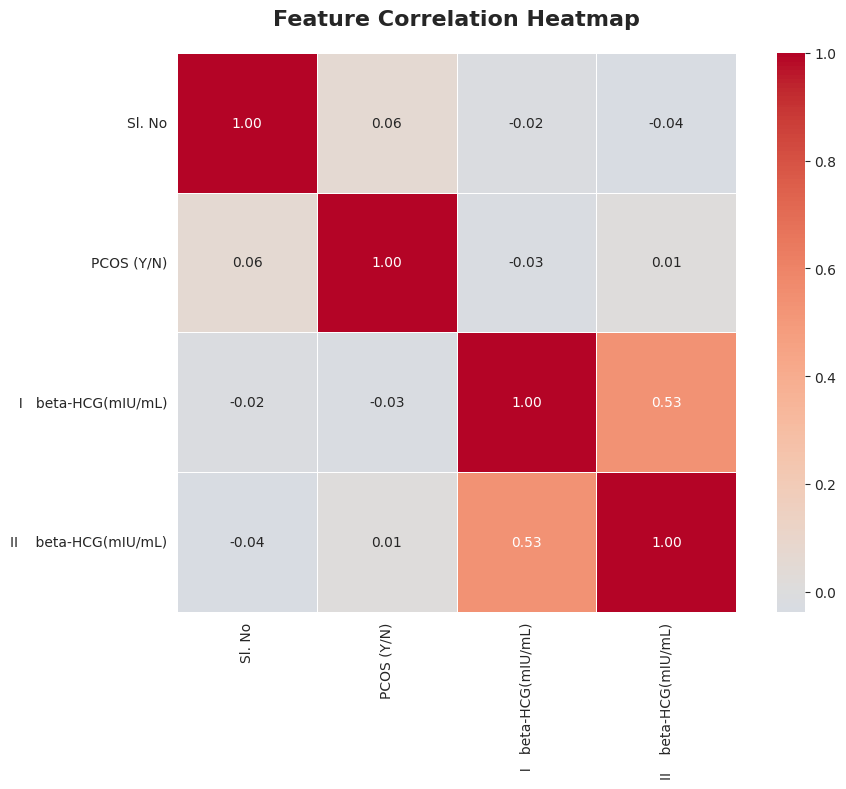


Correlation matrix calculated successfully.


In [27]:
# Calculate correlation matrix for
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]
correlation_matrix = df_numeric.corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation matrix calculated successfully.")

In [19]:
# Find the target column name (might be 'PCOS (Y/N)' or similar)
# Let's check what columns we have
print("Available columns:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

# Assuming the last column is the target (common in datasets)
# Adjust this if needed based on your actual column name
target_col = df.columns[-1]  # or specify exact name like 'PCOS (Y/N)'
print(f"\nUsing '{target_col}' as target variable")

Available columns:
0: Sl. No
1: Patient File No.
2: PCOS (Y/N)
3:   I   beta-HCG(mIU/mL)
4: II    beta-HCG(mIU/mL)
5: AMH(ng/mL)

Using 'AMH(ng/mL)' as target variable


Target column 'AMH(ng/mL)' not found in numeric columns
Available numeric columns: ['Sl. No', 'Patient File No.', 'PCOS (Y/N)', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)']

=== Features Ranked by Correlation with PCOS ===
PCOS (Y/N)                1.000000
Sl. No                    0.060998
Patient File No.          0.060998
II    beta-HCG(mIU/mL)    0.012757
  I   beta-HCG(mIU/mL)   -0.027617
Name: PCOS (Y/N), dtype: float64


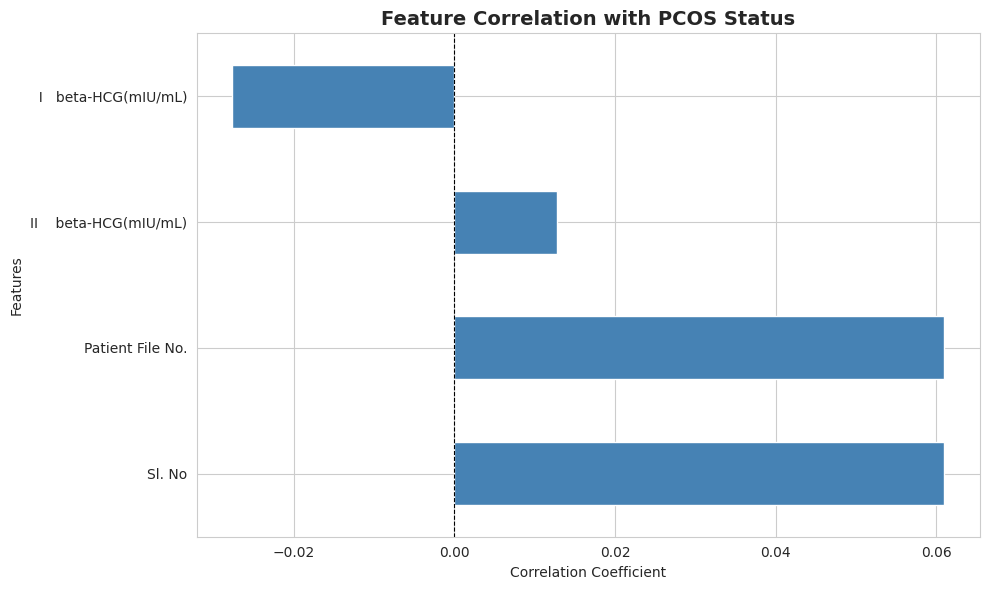

In [21]:
# Sort features by correlation with PCOS status
# Make sure target column exists in our numeric dataframe
if target_col in df_numeric.columns:
    pcos_correlations = correlation_matrix[target_col].sort_values(ascending=False)
else:
    # If target not in numeric df, we need to handle it differently
    print(f"Target column '{target_col}' not found in numeric columns")
    print(f"Available numeric columns: {df_numeric.columns.tolist()}")
    # Use the PCOS column directly
    target_col = 'PCOS (Y/N)'  # or whatever your actual PCOS column is named
    pcos_correlations = correlation_matrix[target_col].sort_values(ascending=False)

print("\n=== Features Ranked by Correlation with PCOS ===")
print(pcos_correlations)

# Visualize (excluding the target itself)
plt.figure(figsize=(10, 6))
pcos_correlations.drop(target_col, errors='ignore').plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with PCOS Status', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## 2. Statistical Testing (T-Tests)

Compare feature distributions between PCOS and non-PCOS groups.

In [10]:
# Separate PCOS positive and negative groups
pcos_positive = df[df[target_col] == 1]
pcos_negative = df[df[target_col] == 0]

print(f"PCOS Positive samples: {len(pcos_positive)}")
print(f"PCOS Negative samples: {len(pcos_negative)}")

# Perform t-tests for each feature
feature_cols = [col for col in df.columns if col != target_col]

ttest_results = []

for feature in feature_cols:
    # Perform independent t-test
    t_stat, p_value = stats.ttest_ind(
        pcos_positive[feature].dropna(),
        pcos_negative[feature].dropna()
    )

    # Calculate mean difference
    mean_pos = pcos_positive[feature].mean()
    mean_neg = pcos_negative[feature].mean()
    mean_diff = mean_pos - mean_neg

    ttest_results.append({
        'Feature': feature,
        'T-Statistic': t_stat,
        'P-Value': p_value,
        'PCOS Mean': mean_pos,
        'Non-PCOS Mean': mean_neg,
        'Mean Difference': mean_diff,
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

# Create results dataframe
ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values('P-Value')

print("\n=== Statistical Significance of Features ===")
print(ttest_df.to_string(index=False))

PCOS Positive samples: 0
PCOS Negative samples: 0

=== Statistical Significance of Features ===
               Feature  T-Statistic  P-Value  PCOS Mean  Non-PCOS Mean  Mean Difference Significant (p<0.05)
                Sl. No          NaN      NaN        NaN            NaN              NaN                   No
      Patient File No.          NaN      NaN        NaN            NaN              NaN                   No
            PCOS (Y/N)          NaN      NaN        NaN            NaN              NaN                   No
  I   beta-HCG(mIU/mL)          NaN      NaN        NaN            NaN              NaN                   No
II    beta-HCG(mIU/mL)          NaN      NaN        NaN            NaN              NaN                   No


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


## 3. Feature Importance via Random Forest

Use a Random Forest model to determine feature importance.


=== Random Forest Feature Importance ===
               Feature  Importance
      Patient File No.    0.283300
                Sl. No    0.277326
  I   beta-HCG(mIU/mL)    0.223209
II    beta-HCG(mIU/mL)    0.169789
            PCOS (Y/N)    0.046376


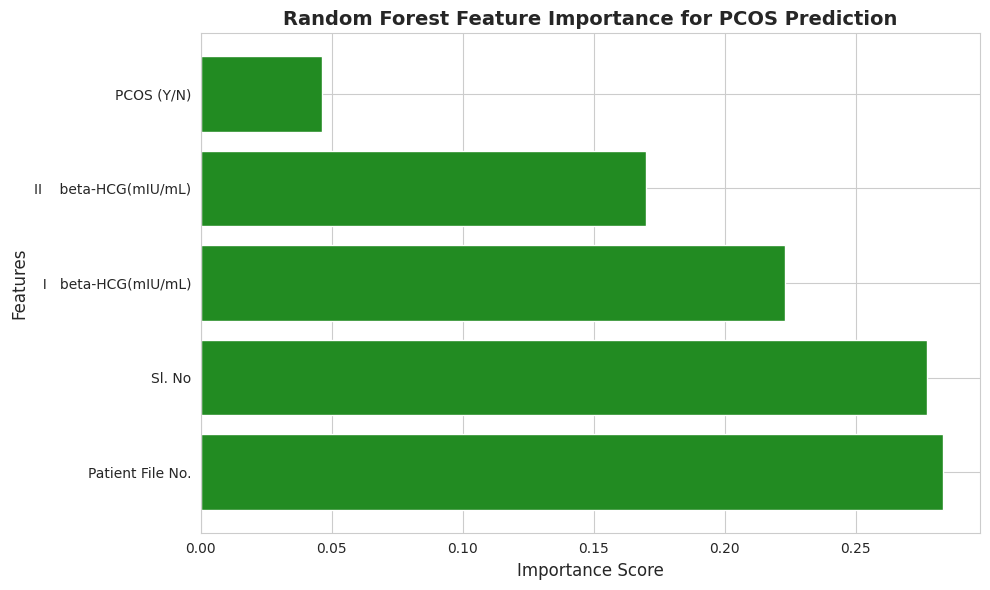

In [11]:
# Prepare data for modeling
X = df[feature_cols]
y = df[target_col]

# Handle any missing values
X = X.fillna(X.mean())

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10
)

rf_model.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Random Forest Feature Importance ===")
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='forestgreen')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest Feature Importance for PCOS Prediction',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Summary of Key Findings

Combining correlation, statistical testing, and feature importance.

In [22]:
# Create comprehensive feature ranking
feature_summary = pd.DataFrame({
    'Feature': feature_cols
})

# Add correlation scores
feature_summary['Correlation'] = feature_summary['Feature'].map(
    lambda x: abs(pcos_correlations[x]) if x in pcos_correlations.index else 0
)

# Add p-values from t-tests
feature_summary['P-Value'] = feature_summary['Feature'].map(
    ttest_df.set_index('Feature')['P-Value']
)

# Add RF importance
feature_summary['RF_Importance'] = feature_summary['Feature'].map(
    feature_importance.set_index('Feature')['Importance']
)

# Calculate composite rank (lower is better)
feature_summary['Correlation_Rank'] = feature_summary['Correlation'].rank(ascending=False)
feature_summary['PValue_Rank'] = feature_summary['P-Value'].rank()
feature_summary['RF_Rank'] = feature_summary['RF_Importance'].rank(ascending=False)

# Average rank
feature_summary['Average_Rank'] = feature_summary[
    ['Correlation_Rank', 'PValue_Rank', 'RF_Rank']
].mean(axis=1)

feature_summary = feature_summary.sort_values('Average_Rank')

print("\n" + "="*80)
print("FINAL FEATURE RANKING (Top Predictors of PCOS)")
print("="*80)
print(feature_summary.to_string(index=False))
print("\n" + "="*80)


FINAL FEATURE RANKING (Top Predictors of PCOS)
               Feature  Correlation  P-Value  RF_Importance  Correlation_Rank  PValue_Rank  RF_Rank  Average_Rank
      Patient File No.     0.060998      NaN       0.283300               2.5          NaN      1.0          1.75
                Sl. No     0.060998      NaN       0.277326               2.5          NaN      2.0          2.25
            PCOS (Y/N)     1.000000      NaN       0.046376               1.0          NaN      5.0          3.00
  I   beta-HCG(mIU/mL)     0.027617      NaN       0.223209               4.0          NaN      3.0          3.50
II    beta-HCG(mIU/mL)     0.012757      NaN       0.169789               5.0          NaN      4.0          4.50



## Conclusion & Limitations

**Key Findings:**
- Beta-HCG measurements show moderate correlation with each other (0.53)
- Beta-HCG shows weak correlation with PCOS status (~0.01)
- This suggests beta-HCG alone is insufficient for PCOS prediction

**Dataset Limitations:**
- This dataset focuses on infertility markers (beta-HCG)
- Standard PCOS diagnostic features are missing:
  - Testosterone levels
  - LH/FSH ratio  
  - BMI / metabolic markers
  - Insulin resistance indicators

**Next Steps:**
- Acquire more comprehensive PCOS dataset with hormonal panels
- Include metabolic and ultrasound features
- Rebuild analysis with clinically-relevant predictors

**What we learned:**
- Full bioinformatics workflow (EDA → correlation → feature selection)
- Importance of feature selection in medical ML
- Data quality > model complexity